# Atmospheric composition distribution by CAMS and GOME-2

### Main goal:
* Compare GOME-2 and CAMS datasets for NO<sub>2</sub>, O<sub>3</sub> and HCHO (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  

In [40]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'O3'

# Define sensor
sensor = 'gome'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 0

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2021-09-01'
end_date = '2021-09-01'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: ('2021-09-01',)


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [7]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 4, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-09-01
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 0.004603 ... 0.006469
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-22T15:07 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [8]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Download and read data as xarray

In [9]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

--2021-09-22 15:07:51--  ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/
           => '.listing'
Resolving acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)... 129.247.254.12
Connecting to acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)|129.247.254.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gome2a/offline/2021/09/01 ... done.
==> PASV ... done.    ==> LIST ... done.

     0K ..                                                     67.1K=0.03s

2021-09-22 15:07:52 (67.1 KB/s) - '.listing' saved [2155]

Removed '.listing'.
Wrote HTML-ized index to 'data/gome/O3/index.html'.
No URLs found in ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/.
File 'data/gome/O3/2021-09-01/A/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901013613_051_METOPA_77149_DLR_04.HDF5' already there; not retrieving.
File 'data/gome/O3/2021-09-01/A/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901031737_051_METOPA_77150_DLR_04.HDF5' already there; not 

In [10]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, satellites)
sensor_ds

/tmp/ipykernel_1984898/2432344042.py:90: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360, time: 1)
Coordinates:
  * latitude    (latitude) float64 -74.3 -73.39 -72.48 ... 86.96 87.87 88.78
  * longitude   (longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * time        (time) datetime64[ns] 2021-09-01
Data variables:
    O3total     (time, latitude, longitude) float64 nan nan nan ... 305.3 nan
    delta_time  (time, latitude, longitude) datetime64[ns] NaT NaT ... NaT

## 4. Match data

In [14]:
for time in sensor_ds.time.values:

    # Reduce data to only one timestamp
    model_ds_time = model_ds.sel(time = time)
    sensor_ds_time = sensor_ds.sel(time = time)

    sensor_ds_time = subset(sensor_ds_time, bbox)

    # Subset model data
    model_ds_time = subset(model_ds_time, bbox)

    # Transform into dataframe
    match_df = sensor_ds_time.to_dataframe()
    match_df = match_df.reset_index(level = ['latitude', 'longitude'])

    # Prepare dataframe for following functions
    year = time.astype('datetime64[D]').astype(str).split('-')[0]
    month = time.astype('datetime64[D]').astype(str).split('-')[1]
    day = time.astype('datetime64[D]').astype(str).split('-')[2]
    match_df[match_df['delta_time'].isnull()]['delta_time'] = dt.datetime(int(year), int(month), int(day), 12, 0, 0)
        
match_df

,latitude,longitude,O3total,delta_time,time
0,-74.297600,-179.999695,NaN,NaT,2021-09-01
1,-74.297600,-178.999704,NaN,NaT,2021-09-01
2,-74.297600,-177.999713,NaN,NaT,2021-09-01
3,-74.297600,-176.999722,NaN,NaT,2021-09-01
4,-74.297600,-175.999731,NaN,NaT,2021-09-01
...,...,...,...,...,...
29875,0.410456,174.997055,NaN,NaT,2021-09-01
29876,0.410456,175.997046,269.615570,2021-09-01 20:42:12,2021-09-01
29877,0.410456,176.997037,269.110246,2021-09-01 20:42:12,2021-09-01
29878,0.410456,177.997028,272.960434,2021-09-01 20:42:12,2021-09-01


In [25]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR EST. TIME: 2021-09-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,O3total,delta_time,time,step_index,model_column
0,-74.297600,-179.999695,NaN,2021-09-01 12:00:00,2021-09-01,2,212.728699
1,-74.297600,-178.999704,NaN,2021-09-01 12:00:00,2021-09-01,2,214.122284
2,-74.297600,-177.999713,NaN,2021-09-01 12:00:00,2021-09-01,2,215.241745
3,-74.297600,-176.999722,NaN,2021-09-01 12:00:00,2021-09-01,2,216.435120
4,-74.297600,-175.999731,NaN,2021-09-01 12:00:00,2021-09-01,2,216.952026
...,...,...,...,...,...,...,...
29875,0.410456,174.997055,NaN,2021-09-01 12:00:00,2021-09-01,2,257.791077
29876,0.410456,175.997046,269.615570,2021-09-01 20:42:12,2021-09-01,3,259.931763
29877,0.410456,176.997037,269.110246,2021-09-01 20:42:12,2021-09-01,3,258.962128
29878,0.410456,177.997028,272.960434,2021-09-01 20:42:12,2021-09-01,3,257.626343


## 5. Merge data and calculate difference

In [26]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

O3total  step_index  model_column  \
latitude   longitude   time                                               
-74.297600 -179.999695 2021-09-01         NaN           2    212.728699   
           -178.999704 2021-09-01         NaN           2    214.122284   
           -177.999713 2021-09-01         NaN           2    215.241745   
           -176.999722 2021-09-01         NaN           2    216.435120   
           -175.999731 2021-09-01         NaN           2    216.952026   
...                                       ...         ...           ...   
 0.410456   174.997055 2021-09-01         NaN           2    257.791077   
            175.997046 2021-09-01  269.615570           3    259.931763   
            176.997037 2021-09-01  269.110246           3    258.962128   
            177.997028 2021-09-01  272.960434           3    257.626343   
            178.997018 2021-09-01  267.267873           3    257.819824   

                                   difference  
latitude   longitude   time                    
-74.297600 -179.999695 2021-09-01         NaN  
           -178.999704 2021-09-01         NaN  
           -177.999713 2021-09-01         NaN  
           -176.999722 2021-09-01         NaN  
           -175.999731 2021-09-01         NaN  
...                                       ...  
 0.410456   174.997055 2021-09-01         NaN  
            175.997046 2021-09-01    9.683807  
            176.997037 2021-09-01   10.148119  
            177.997028 2021-09-01   15.334091  
            178.997018 2021-09-01    9.448049  

[29880 rows x 4 columns]

In [27]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,O3total,step_index,model_column,difference
count,22537.000000,29880.000000,29880.000000,22537.000000
mean,308.575172,1.828012,290.926904,7.858420
std,42.993397,0.964915,44.431858,8.231377
min,173.133179,0.000000,181.015274,-38.354248
25%,279.795746,1.000000,266.867958,3.425598
50%,301.530756,2.000000,285.930664,6.692310
75%,332.495367,3.000000,314.776649,10.824348
max,482.561749,3.000000,465.948944,81.936493


## 6. Show comparison plots

### Select plot dates

In [28]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-09']


### Select plot extent

In [29]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 0))


### Compare CAMS and GOME-2 total columns

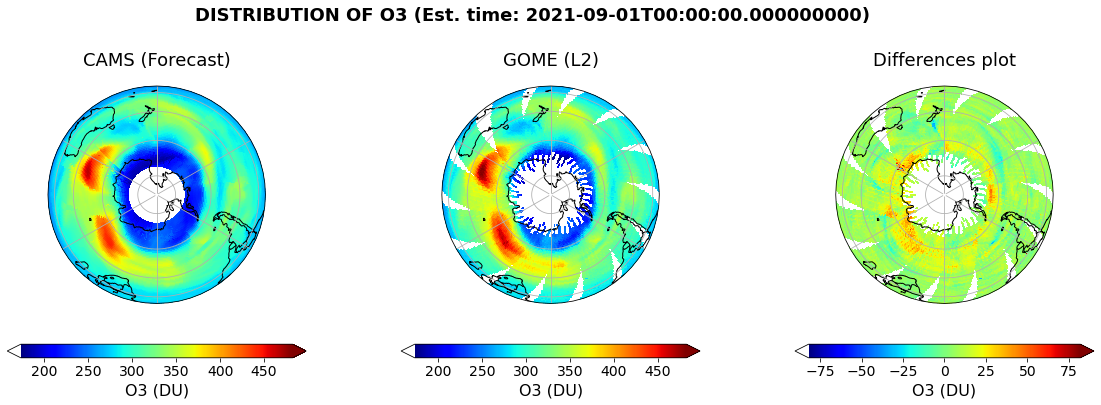

In [41]:
# Choose distribution (aggregated or individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection=ccrs.Orthographic(180, -90)
color_scale = 'jet'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection, 
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [31]:
coords_search_list = (-80, 30,
                      -70, 30,
                      -50, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

,,,,,O3total,step_index,model_column,difference
lat_search,lon_search,latitude,longitude,time,,,,
-80,30,-72.475452,34.998337,2021-09-01,208.040642,1,198.627594,9.413048
-70,30,-68.831157,28.998392,2021-09-01,228.831192,1,216.871353,11.959839
-50,30,-49.698606,29.998383,2021-09-01,410.449628,1,388.849579,21.600049


## 8. Scatter plots by bbox

Fit equation: O3_model = O3_sensor * 0.95 + (6.98E+00)
Coefficient of determination (R2): 0.96


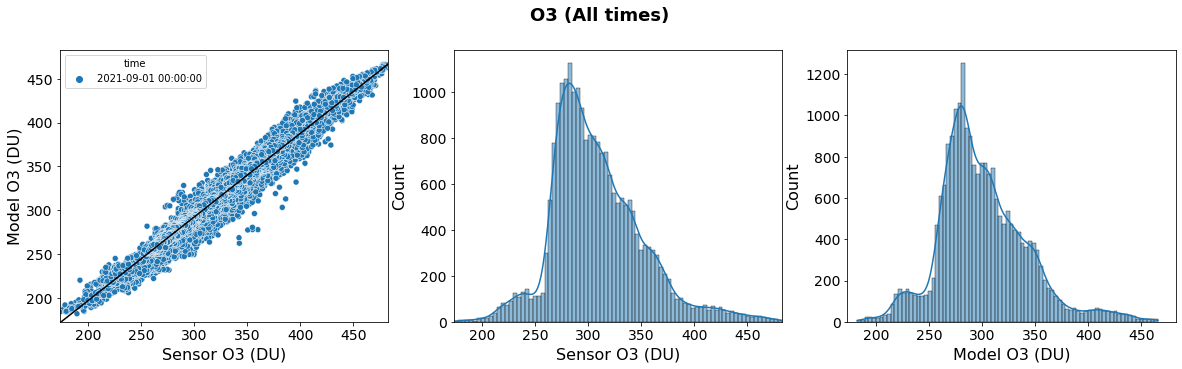

In [32]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [33]:
summary

,Period,Location,Score,Coefficient,Intercept
0,[2021-09-01T00:00:00.000000000],"((-180, -90), (180, 0))",0.963484,0.951902,6.983453


## 9. Scatter plots by season

Fit equation: O3_model = O3_sensor * 0.95 + (6.98E+00)
Coefficient of determination (R2): 0.96


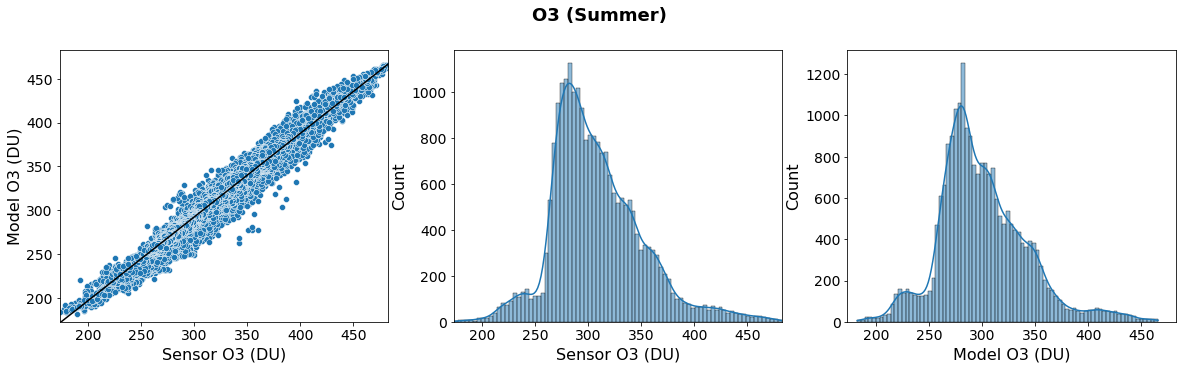

In [34]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [35]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((-180, -90), (180, 0))",0.963484,0.951902,6.983453


## 10. Scatter plots by country (Google API required!)

In [36]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [37]:
#summary